In [77]:
import numpy as np 
from numpy import sin, cos, sqrt
import matplotlib.pyplot as plt 
from scipy.interpolate import interp1d
from SynGenLoss.Model2.aabjora_model import AabjoraModel 

In [7]:
data = AabjoraModel().md 
data.X_q

0.676

In [ ]:
class CapabilityDiagram: 
    def __init__(self, gen_data, P_min_pu, P_max_pu, N_vals=1000): 
        self.X_d = gen_data.X_d
        self.X_q = gen_data.X_q
        self.P_min = P_min_pu 
        self.P_max = P_max_pu
        self.N_vals = N_vals

        # TODO: Find proper values for these
        self.E_min = 0.1
        self.Ifd_max = 2.03 
        self.delta_max = 30 * np.pi/180
        
    def calc_L1(self, V_g): 
        """Minimum internal voltage limit / UEL"""
        th = np.linspace(0, np.pi/2, self.N_vals)
        R = (0.5*V_g**2 * (self.X_d-self.X_q))/(self.X_d*self.X_q) + self.E_min 
        c = (0.5*V_g**2 * (self.X_d+self.X_q))/(self.X_d*self.X_q) - self.E_min 
        L1 = np.array([R*np.cos(th) - c, R*np.sin(th)])
        return L1

    def calc_L2(self, V_g): 
        """Rotor Stability Limit"""
        eq = np.linspace(0, 2, self.N_vals) #internal voltages
        a = eq*self.X_q / (V_g*(self.X_d-self.X_q))
        b = np.sqrt(a**2 + 8)
        cos_delta = 0.25 * (b - a) #stability factor ?
        delta = np.arccos(cos_delta) 
        c = eq*V_g / self.X_d * np.sin(delta) 
        d = 0.5*V_g**2 * (self.X_d - self.X_q)/self.X_d * self.X_q * np.sin(2*delta)
        P = c + d 
        e = V_g**2 *((self.X_d-self.X_q)/self.X_d * self.X_q) * np.sin(delta)**2 
        f = V_g**2 / self.X_d 
        Q = eq*V_g/self.X_d * np.cos(delta) - f - e
        stab_m = 0.75 #Stability marigin (comes from??)
        S = (P + Q*1j) * stab_m 
        L2 = np.array([np.imag(S) , np.real(S)])
        return L2

    def calc_L3(self, V_g):
        """Stator current limit"""
        th = np.linspace(np.pi/2, -np.pi/2, self.N_vals)
        I = np.cos(th) + 1j*np.sin(th)
        S = np.conj(I)*V_g
        L3 = np.array([np.imag(S), np.real(S)])*V_g
        return L3

    def calc_L4(self, V_g):
        """Rotor thermal limit"""
        th = np.linspace(0, 95.5, self.N_vals)*np.pi/180
        R = np.sqrt((self.Qn + 1/self.xq_pu)**2 + self.Pn**2)
        x = R*np.sin(th) - 1/self.xq_pu 
        y = R*np.cos(th)
        L4 = np.array([x, y])
        return L4
    
    def get_Q_lims(self, V: float, P_pu: float) -> Sequence[float]: 
        """Finds the Q_pu limits for a given voltage and active power- \n 
        The active power value is limited to be within P_min and P_max, considering \n 
        both set limitations and the capability diagram upper limit. \n 
        Returns P_actual_pu, Q_min_pu, Q_max_pu """
        L1 = self.calc_L1(V, 0.1) 
        L2 = self.calc_L2(V) 
        L3 = self.calc_L3(V) 
        L4 = self.calc_L4() 
        
        Q_min_curve = self.Q_min_curve(L1, L2, L3)
        Q_max_curve = self.Q_max_curve(L3, L4)
        P_min = np.max([self.P_min, Q_min_curve.x.min(), Q_max_curve.x.min()])
        P_max = np.min([self.P_max, Q_min_curve.x.max(), Q_max_curve.x.max()])
        P_pu = np.clip(P_pu, P_min, P_max)
        Q_min_pu = Q_min_curve(P_pu)
        Q_max_pu = Q_max_curve(P_pu)
        return P_pu, Q_min_pu, Q_max_pu
        
    def Q_min_curve(self, L1_vals, L2_vals, L3_vals): 
        L3_min_side = L3_vals.T[:np.argmax(L3_vals[1])].T
        L1 = interp1d(L1_vals[1], L1_vals[0])
        L2 = interp1d(L2_vals[1], L2_vals[0]) 
        L3 = interp1d(L3_min_side[1], L3_min_side[0]) 

        x_min = np.max([L1.x.min(), L2.x.min()])
        x_max = np.min([L1.x.max(), L2.x.max()])
        intersect1 = brenth(lambda x: L1(x) - L2(x), a=x_min, b=x_max)

        x_min = np.max([L2.x.min(), L3.x.min()])
        x_max = np.min([L2.x.max(), L3.x.max()])
        intersect2 = brenth(lambda x: L2(x) - L3(x), a=x_min, b=x_max)

        L1 = L1_vals.T[L1_vals[1] < intersect1]
        L2 = L2_vals.T[np.logical_and(L2_vals[1] >= intersect1, L2_vals[1] < intersect2)]
        L3 = L3_min_side.T[L3_min_side[1] >= intersect2]
        L = np.concatenate((L1, L2, L3), axis=0).T
        L = interp1d(L[1], L[0], kind='linear') 
        return L
    
    def Q_max_curve(self, L3_vals, L4_vals): 
        L3_max_side = L3_vals.T[np.argmax(L3_vals[1]):].T
        L3 = interp1d(L3_max_side[1], L3_max_side[0]) 
        L4 = interp1d(L4_vals[1], L4_vals[0])

        x_min = np.max([L3.x.min(), L4.x.min()])
        x_max = np.min([L3.x.max(), L4.x.max()])
        intersect1 = brenth(lambda x: L3(x) - L4(x), a=x_min, b=x_max)

        L3 = L3_max_side.T[L3_max_side[1] > intersect1]
        L4 = L4_vals.T[np.logical_and(L4_vals[1] <= intersect1, L4_vals[1] >= 0)]
        L = np.concatenate((L3, L4), axis=0).T
        L = interp1d(L[1], L[0], kind='linear') 
        return L

In [90]:
def objective(X, V_g, R_a, X_d, X_q, X_l, Ifd_max, P_g, SG10, SG12): 
    X_ad_un = X_d - X_l
    X_aq_un = X_q - X_l 
    exp = np.log(1.2*SG12/SG10) / np.log(1.2)
    
    [e_d, e_q, i_d, i_q, Q_g, delta, X_ad, X_aq] = X 
    phi = np.arctan(Q_g / P_g)
    I_t = np.sqrt(i_d**2 + i_q**2)
    X_d = X_ad + X_l 
    X_q = X_aq + X_l 
    
    # Saturation: 
    psi_d = e_q + R_a*i_q 
    psi_q = -e_d - R_a*i_d 
    psi_m = np.sqrt((psi_d + X_l*i_d)**2 + (psi_q + X_l*i_q)**2) 
    c_sat = SG10*psi_m**exp / psi_m 
    sat_d = 1.0 / (1 + c_sat)
    sat_q = 1.0 / (1 + c_sat*X_aq_un/X_ad_un)
    
    f1 = e_d -  (V_g * np.sin(delta))
    f2 = e_q -  (Ifd_max*X_ad - X_d*i_d - R_a*i_q) # e_q
    f3 = i_d -  (I_t * np.sin(delta + phi))
    f4 = i_q -  (I_t * np.cos(delta + phi))
    f5 = Q_g -  (e_q*i_d - e_d*i_q) 
    f6 = delta -(np.arctan((X_q*I_t*np.cos(phi) - R_a*I_t*np.sin(phi)) / (V_g + R_a*I_t*np.cos(phi) + X_q*I_t*np.sin(phi))))
    f7 = X_ad - (X_ad_un * sat_d)
    f8 = X_aq - (X_aq_un * sat_q)
    
    return np.array([f1, f2, f3, f4, f5, f6, f7, f8])

def objective2(X, E_t, P_g, Ifd_max, R_a, X_ad_un, X_aq_un, X_l, SG10, SG12): 
    """The variable X is an array of all unknowns. All 17 equations should equal 0 in order to solve the system of equations. """
    #         0    1   2    3    4   5   6   7   8     9     10     11     12     13    14    15    16    17   18
    #  X = [delta, Xd, Xq, Xad, Xaq, ed, eq, id, iq, psi_d, psi_q, sat_d, sat_q, c_sat, exp, psi_m, I_t, phi, Q_g]
    delta, X_d, X_q, X_ad, X_aq, e_d, e_q, i_d, i_q, psi_d, psi_q, sat_d, sat_q, c_sat, exp, psi_m, I_t, phi, Q_g = X
    f1 =  delta  -  (np.arctan( (X_q*I_t*cos(phi) - R_a*I_t*sin(phi)) / (E_t + R_a*I_t*cos(phi) + X_q*I_t*sin(phi)) ) ) # delta
    f2 =  X_d  -    (X_ad + X_l) # X_d_sat 
    f3 =  X_q  -    (X_aq + X_l) # X_q_sat
    f4 =  X_ad  -   (X_ad_un * sat_d) # X_ad_sat
    f5 =  X_aq  -   (X_aq_un * sat_q) # X_aq_sat 
    f6 =  e_d  -    (E_t*sin(delta)) # e_d
    f7 =  e_q  -    (E_t*cos(delta)) # e_q
    f8 =  i_d  -    (I_t*sin(phi + delta)) # i_d
    f9 =  i_q  -    (I_t*cos(phi + delta)) # i_q
    f10 = psi_d  -  (e_q + R_a*i_q) # psi_d
    f11 = psi_q -   (-e_d - R_a*i_d) # psi_q 
    f12 = sat_d -   (1.0 / (1.0 + c_sat)) # sat_d
    f13 = sat_q -   (1.0/(1 + X_aq_un/X_ad_un * c_sat)) # sat_q
    f14 = c_sat -   (SG10 * psi_m**exp / psi_m) # c_sat 
    f15 = exp -     (np.log(1.2 * SG12/SG10) / np.log(1.2)) # exp 
    f16 = psi_m -   (np.sqrt((psi_d + X_l*i_d)**2 + (psi_q + X_l*i_q)**2)) # psi_m
    f17 = I_t -     (np.sqrt(P_g**2 + Q_g**2)/E_t) 
    f18 = phi -     (np.arctan(Q_g / P_g) ) 
    f19 = Q_g -     (e_q*i_d - e_d*i_q)
    return np.array([f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f12, f13, f14, f15, f16, f17, f18, f19])

def init_calc(V_g, R_a, X_d, X_q, X_l, P_g): 
    Q_g_est = 0.436 
    I_t = (P_g**2 + Q_g_est**2)/V_g
    phi = np.arctan(Q_g_est / P_g)
    delta = np.arctan((X_q*I_t*np.cos(phi) - R_a*I_t*np.sin(phi)) / (V_g + R_a*I_t*np.cos(phi) + X_q*I_t*np.sin(phi)))
    e_d = V_g * np.sin(delta)
    e_q = V_g * np.cos(delta)
    i_d = I_t * np.sin(delta + phi)
    i_q = I_t * np.cos(delta + phi)
    return np.array([e_d, e_q, i_d, i_q, Q_g_est, delta, X_d - X_l, X_q - X_l])

def init_calc2(e_d, e_q, i_d, i_q, Q_g, delta, X_ad, X_aq, X_l, R_a, SG10, SG12, X_ad_un, X_aq_un, P_g, V_g): 
    X_d = X_ad + X_l 
    X_q = X_aq + X_l 
    psi_d = e_q + R_a*i_q
    psi_q = -e_d - R_a*i_d 
    psi_m =   (np.sqrt((psi_d + X_l*i_d)**2 + (psi_q + X_l*i_q)**2)) # psi_m
    exp   =   (np.log(1.2 * SG12/SG10) / np.log(1.2)) # exp
    c_sat =   (SG10 * psi_m**exp / psi_m) # c_sat 
    sat_d =   (1.0 / (1.0 + c_sat)) # sat_d
    sat_q =   (1.0/(1 + X_aq_un/X_ad_un * c_sat)) # sat_q
    I_t   =   (np.sqrt(P_g**2 + Q_g**2)/V_g) 
    phi   =   (np.arctan(Q_g / P_g) ) 
    Q_g   =   (e_q*i_d - e_d*i_q)
    return np.array([delta, X_d, X_q, X_ad, X_aq, e_d, e_q, i_d, i_q, psi_d, psi_q, sat_d, sat_q, c_sat, exp, psi_m, I_t, phi, Q_g])
    

In [103]:
from scipy.optimize import root 
G1 = AabjoraModel() 
V_g = 1.0
R_a = G1.md.R_a
X_d = G1.md.X_d
X_q = G1.md.X_q
X_l = G1.md.X_l
Ifd_max = 1.9975727943692592
P_g = 0.3
SG10 = G1.md.SG10
SG12 = G1.md.SG12

# X0 = np.array([1.0, 1.0, 1.0, 0.0, 1.0, 0.1])
X0 = init_calc(V_g, R_a, X_d, X_q, X_l, P_g)

sol = root(objective, X0, args=(V_g, R_a, X_d, X_q, X_l, Ifd_max, P_g, SG10, SG12), tol=1e-9)
e_d, e_q, i_d, i_q, Q_g, delta, X_ad, X_aq = sol.x

X0 = init_calc2(e_d, e_q, i_d, i_q, Q_g, delta, X_ad, X_aq, X_l, R_a, SG10, SG12, G1.md.X_ad_un, G1.md.X_aq_un, P_g, V_g)
sol = root(objective2, X0, args=(V_g, P_g, Ifd_max, R_a, G1.md.X_ad_un, G1.md.X_aq_un, X_l, SG10, SG12), tol=1e-9)
delta, X_d, X_q, X_ad, X_aq, e_d, e_q, i_d, i_q, psi_d, psi_q, sat_d, sat_q, c_sat, exp, psi_m, I_t, phi, Q_g = sol.x
Q_g

0.5211263094442571

In [94]:
G1 = AabjoraModel() 
V_g = 1.0
P_g = 0.9
Ifd_max = 1.9975727943692592
R_a = G1.md.R_a
X_d = G1.md.X_d
X_q = G1.md.X_q
X_l = G1.md.X_l
X_ad_un = G1.md.X_ad_un 
X_aq_un = G1.md.X_aq_un 
SG10 = G1.md.SG10
SG12 = G1.md.SG12

X0 = np.array([0.0, X_d, X_q, X_ad_un, X_aq_un, 0.0, V_g, P_g, 0.0, V_g, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, P_g, 0.0, 1.0])
sol = root(objective2, X0, args=(V_g, P_g, Ifd_max, R_a, X_ad_un, X_aq_un, X_l, SG10, SG12), tol=1e-9)

In [83]:
delta, X_d, X_q, X_ad, X_aq, e_d, e_q, i_d, i_q, psi_d, psi_q, sat_d, sat_q, c_sat, exp, psi_m, I_t, phi, Q_g = sol.x

In [84]:
Q_g

0.3906323300280195

In [58]:
G1 = AabjoraModel() 

In [51]:
delta, X_d, X_q, i_d, i_q, i_fd = G1.calculate(0.9, 0.436, 1.0)
i_fd

1.9975727943692592

In [49]:
I_t, i_d, i_q, phi, e_d, e_q, delta, psi_d, psi_q, i_fd, e_fd = G1.init_no_sat(0.9, 0.4495507127682403, 1.0)
i_fd

1.778879851768676

In [54]:
G1.md.SG10

0.198

In [1]:
import numpy as np 
from numpy import sin, cos, sqrt, arctan 
from scipy.optimize import root
import matplotlib.pyplot as plt 

In [2]:
def funcs(X, x_d, x_q, x_p, r_a, b_v, k, Cm, m, V_g, P, I_f): 
    e_g, e_p, delta, theta, Q = X 
    I_a = sqrt(P**2 + Q**2)/V_g
    phi = arctan(Q/P)
    f1 = (e_g - e_p)/b_v + k*(e_p + Cm*e_p**m) - I_f
    f2 = V_g*cos(delta) + r_a*I_a*cos(delta+phi) + x_d*I_a*sin(delta+phi) - e_g
    f3 = V_g*cos(theta) + r_a*I_a*cos(theta+phi) + x_p*I_a*sin(theta+phi) - e_p 
    f4 = arctan((I_a*(x_q*cos(phi) - r_a*sin(phi))) / (V_g + I_a*(r_a*cos(phi) + x_q*sin(phi)))) - delta 
    f5 = arctan((I_a*(x_p*cos(phi) - r_a*sin(phi))) / (V_g + I_a*(r_a*cos(phi) + x_p*sin(phi)))) - theta 
    return np.array([f1,f2,f3,f4,f5])

def calc_L4(): 
    I_f_max = 2.0
    P_vals = np.linspace(1e-3, 1.0, 100)
    Q_vals = []
    for P in P_vals: 
        X0 = np.array([V_g_test, 0.1*V_g_test, 0, 0, P])
        sol = root(funcs, X0, args=(x_d, x_q, x_p, r_a, b_v, k, Cm, m, V_g_test, P, I_f_max))
        Q = sol.x[-1]
        Q_vals.append(Q)

V_g = 1.0 
I_f = 3 
P = 0.5 
x_d = 1.059 
x_q = 0.676 
x_p = 0.144 
r_a = 0.002 
b_v = 1.0 
Cm = 0.16 
m = 7 
k = 1.0308 

X0 = np.array([V_g, 0.1*V_g, 0, 0, P])

In [5]:
V_g_vals = [0.8, 1.0, 1.1]
I_f_max = 2.0
P_vals = np.linspace(1e-3, 1.0, 100)
Q_vals_tot = []
for V_g_test in V_g_vals:
    Q_vals = []
    for P in P_vals: 
        X0 = np.array([V_g_test, 0.1*V_g_test, 0, 0, P])
        sol = root(funcs, X0, args=(x_d, x_q, x_p, r_a, b_v, k, Cm, m, V_g_test, P, I_f_max))
        Q = sol.x[-1]
        Q_vals.append(Q)
    Q_vals_tot.append(Q_vals)


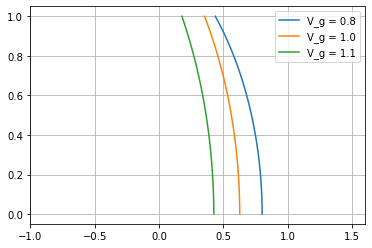

In [6]:
plt.plot(Q_vals_tot[0], P_vals, label=f"V_g = {V_g_vals[0]}")
plt.plot(Q_vals_tot[1], P_vals, label=f"V_g = {V_g_vals[1]}")
plt.plot(Q_vals_tot[2], P_vals, label=f"V_g = {V_g_vals[2]}")
plt.xlim(-1, 1.6)
plt.grid()
plt.legend()
plt.show()